In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scvelo as scv

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset
from symsimDataset import SymsimDataset, SymsimBranch
from unsupervised_loss import UnsupervisedLoss

import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from model.mymodel import MyModel, GraphSAGEModel, FCModel, veloModel, DiffusionModel
from math import sqrt
import scprep

import utils

from torch_geometric.data import Data

In [2]:
dataset = SymsimDataset(root="data/")
datatest = SymsimBranch(root="data/")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset.num_features

f spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Trying to set attribute `.obs` of view, copying.
Skip filtering by dispersion since number of variables are less than `n_top_genes`
Logarithmized X.
300
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Trying to set attribute `.obs` of view, copying.
Skip filtering by dispersion since number of variables are less than `n_top_genes`
Logarithmized X.
300
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacenc

300

In [3]:
def train(train_loader, lamb = None):
    model.train()

    total_loss = 0
    mse = nn.MSELoss()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        """
        Note that here I change the output of the model to incorporate the adj matrix (after the sigmoid transform)
        """
        # output = model(data)
        output, node_embed, adj = model(data)

        loss = 0
        if lamb:
            adj = adj.numpy()
            # eliminate self node
            adj = adj - adj[0,0] * np.diag(np.ones(adj.shape[0]))
            train_nodes = np.arange(adj.shape[0])

            unsupervised_loss = unsup_loss.UnsupervisedLoss(adj = adj, train_nodes=train_nodes, device = device)
            nodes_batch = np.asarray(list(unsupervised_loss.extend_nodes(nodes=train_nodes, num_neg=6)))
            loss_net = unsupervised_loss.get_loss_sage(node_embed, nodes_batch)

            loss = lamb * loss_net


        label = data.y.to(device)
        # pearson correlation loss
        vx = output - torch.mean(output)
        vy = label - torch.mean(label)
        loss += -torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))


        loss.backward()
        total_loss += data.num_graphs * loss.item()
        optimizer.step()

    return float(total_loss / len(train_loader.dataset))

def test(loader):
    model.eval()
    
    correct = []
    predict = []
    for data in loader:
        data = data.to(device)
        label = data.y.detach().cpu().numpy().reshape(-1)
        
        pred,_,_ = model(data)

        pred = pred.detach().cpu().numpy().reshape(-1)
        correct.extend(label)
        predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)

    vx = predict - np.mean(predict)
    vy = correct - np.mean(correct)
    neg_pearson_loss = -np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))

    return neg_pearson_loss

In [4]:
t = np.arange(1,10)
# dataset for training
train_mask = list(t) + list(t+10) + list(t+20) + list(t+30) + list(t+40) + list(t+50) + list(t+60) + list(t+70) + list(t+80) + list(t+90) + list(t+100) + list(t +110) + list(t+120) + list(t+130) + list(t+140)

# dataset for validation
val_mask = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]


In [5]:
# mask the dataset
train_loader = DataLoader(dataset[train_mask], batch_size=1, shuffle=True)
val_loader = DataLoader(dataset[val_mask], batch_size=1)

model = DiffusionModel(dataset.num_features, hidden1 = 256, hidden2 = 128, max_diffusion = 2, include_reversed = True, device = device).to(device)

# reset parameters
model.reset_parameters()
print(model)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=0.05)

train_list = []
val_list = []
for epoch in range(0, 41):

    train_loss = train(train_loader,lamb=None)
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)# mask the dataset

Path = "./Diffusion_symsim.pt"
torch.save(model.state_dict(), Path)

DiffusionModel(
  (conv1): GraphDiffusion (300 -> 256)
  (conv2): GraphDiffusion (256 -> 128)
  (lin): Linear(in_features=128, out_features=1, bias=True)
)
Epoch: 000, Loss: -0.8407, Train: -0.9414, Val: -0.9183
Epoch: 010, Loss: -0.9795, Train: -0.9643, Val: -0.9263
Epoch: 020, Loss: -0.9836, Train: -0.9612, Val: -0.9194
Epoch: 030, Loss: -0.9840, Train: -0.9656, Val: -0.9314
Epoch: 040, Loss: -0.9868, Train: -0.9684, Val: -0.9198


In [5]:
batch_size = 1
Path = "./Diffusion_symsim.pt"

train_loader = DataLoader(dataset[train_mask], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset[val_mask], batch_size=1)

model = DiffusionModel(dataset.num_features, hidden1 = 256, hidden2 = 128, max_diffusion = 2, include_reversed = True, device = device).to(device)
model.load_state_dict(torch.load(Path))
model.eval()

DiffusionModel(
  (conv1): GraphDiffusion (300 -> 256)
  (conv2): GraphDiffusion (256 -> 128)
  (lin): Linear(in_features=128, out_features=1, bias=True)
)

0.93872505


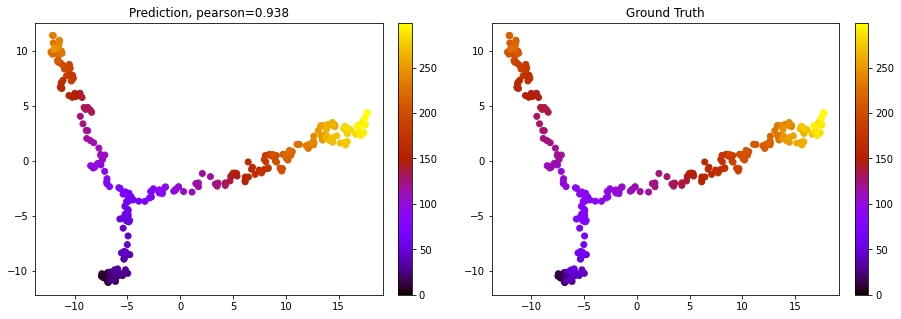

<Figure size 1080x360 with 0 Axes>

0.97505456


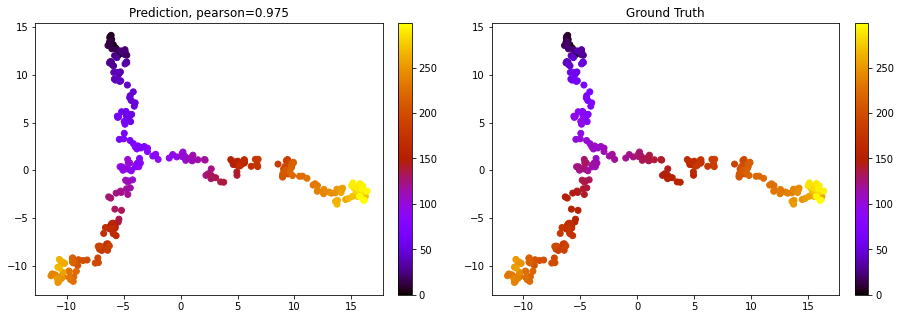

<Figure size 1080x360 with 0 Axes>

0.97528374


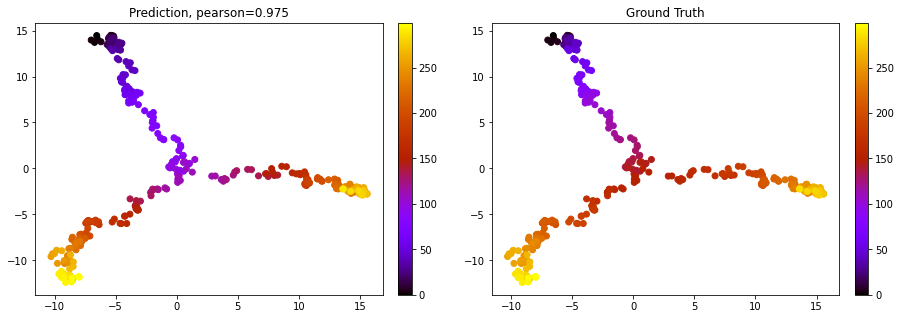

<Figure size 1080x360 with 0 Axes>

0.94862247


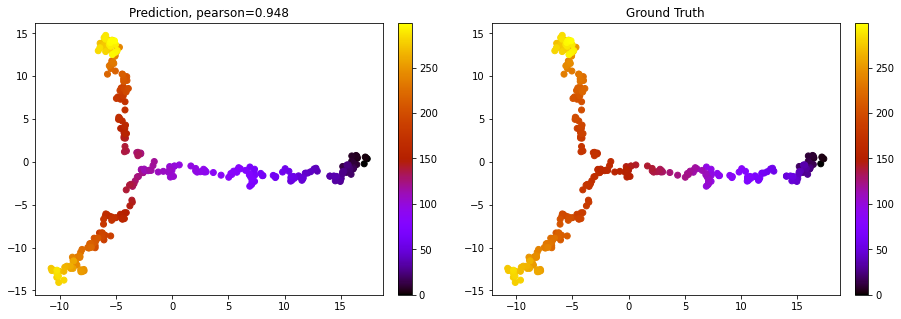

<Figure size 1080x360 with 0 Axes>

0.945482


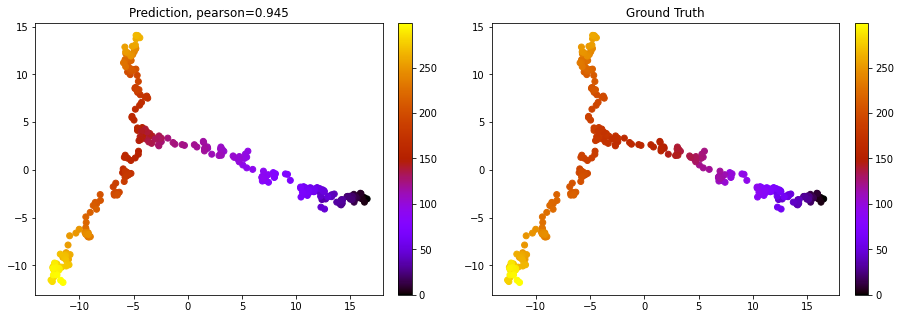

<Figure size 1080x360 with 0 Axes>

0.9629484


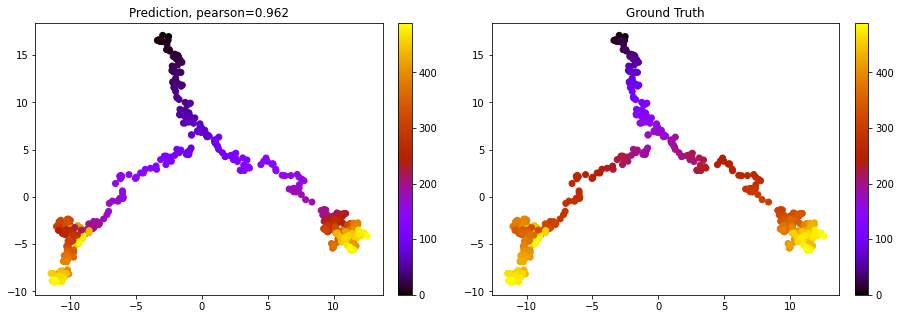

<Figure size 1080x360 with 0 Axes>

0.87358


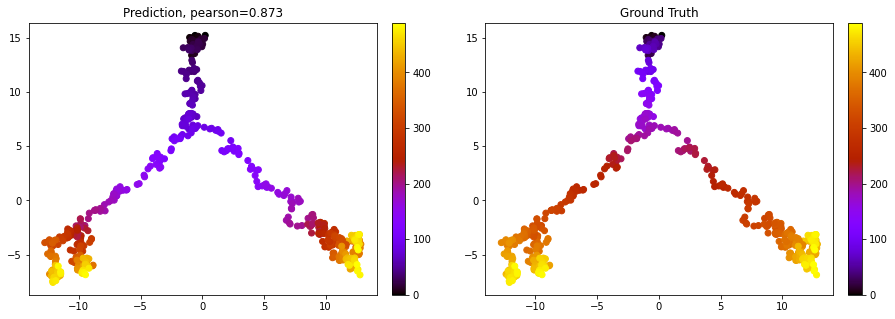

<Figure size 1080x360 with 0 Axes>

0.9653288


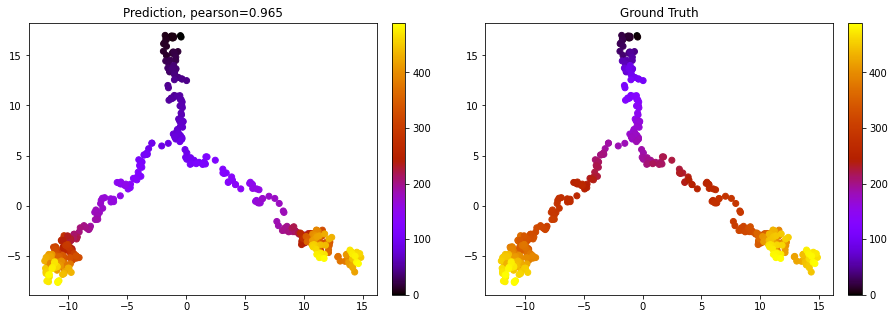

<Figure size 1080x360 with 0 Axes>

0.9554109


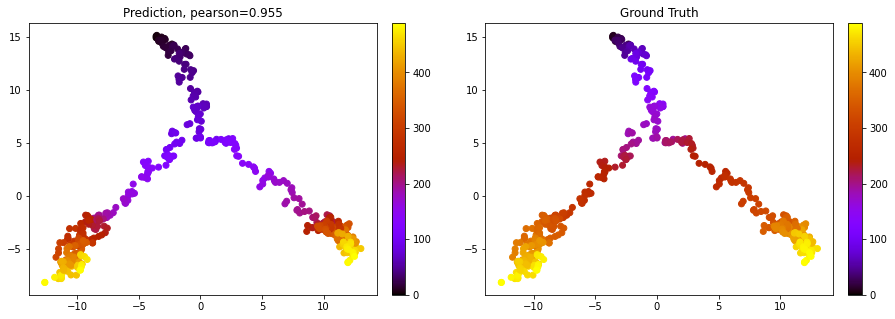

<Figure size 1080x360 with 0 Axes>

0.98171675


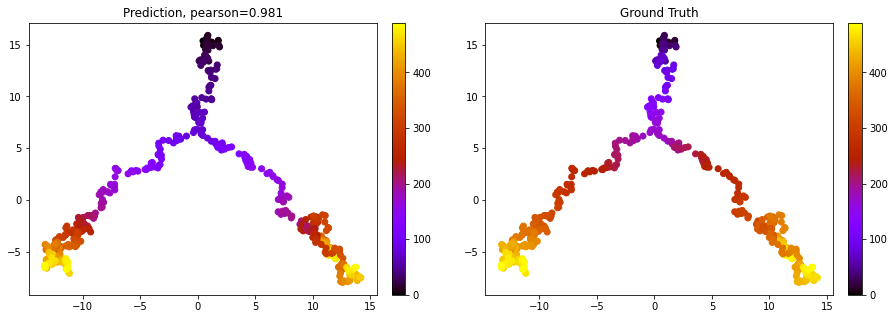

<Figure size 1080x360 with 0 Axes>

0.9137324


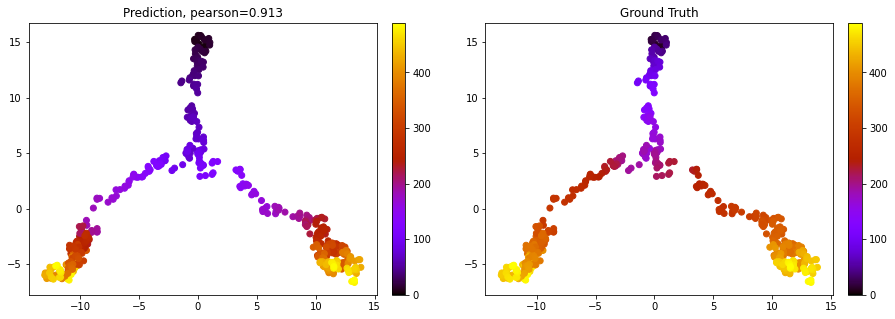

<Figure size 1080x360 with 0 Axes>

0.8016142


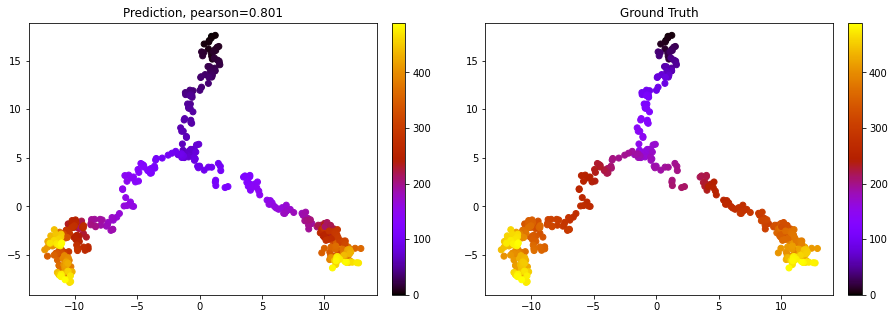

<Figure size 1080x360 with 0 Axes>

0.96326554


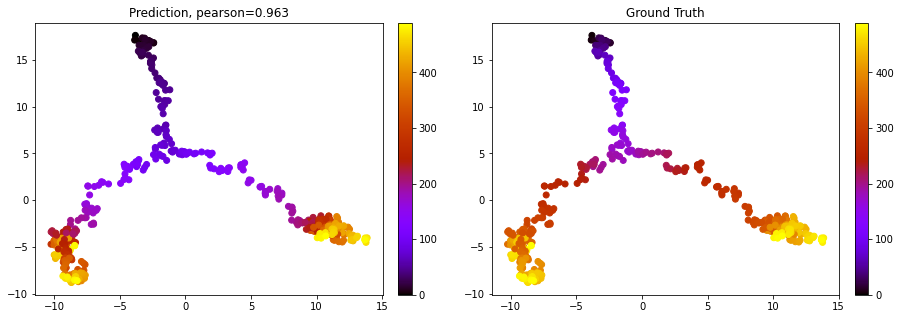

<Figure size 1080x360 with 0 Axes>

0.98323417


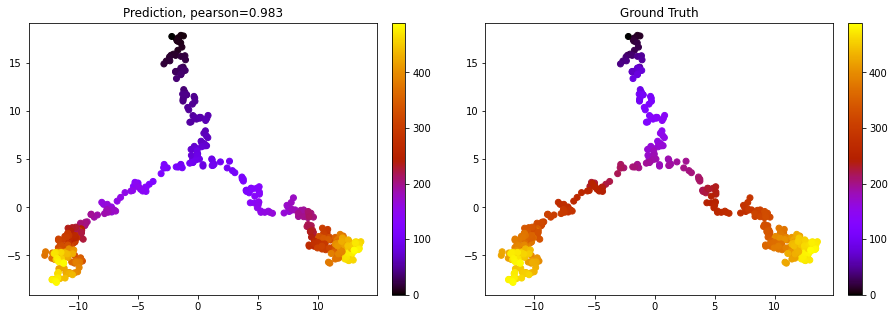

<Figure size 1080x360 with 0 Axes>

0.9127992


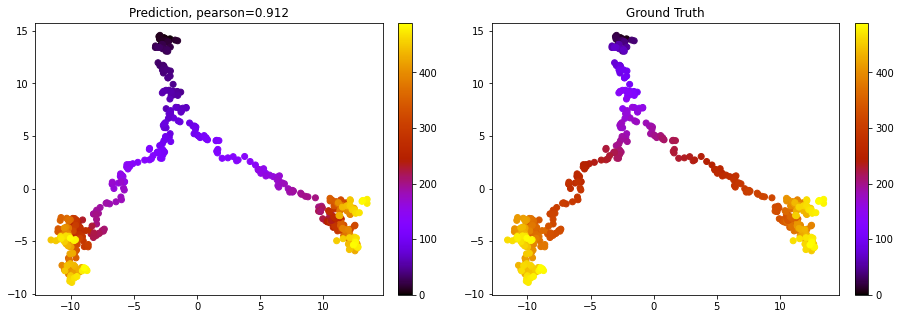

<Figure size 1080x360 with 0 Axes>

In [6]:
for idx, data in enumerate(val_loader):
    # if idx == 0:
    #     break
    utils.scatter(model, data, method='pca', metric='pearson', coloring="order")

0.9870104


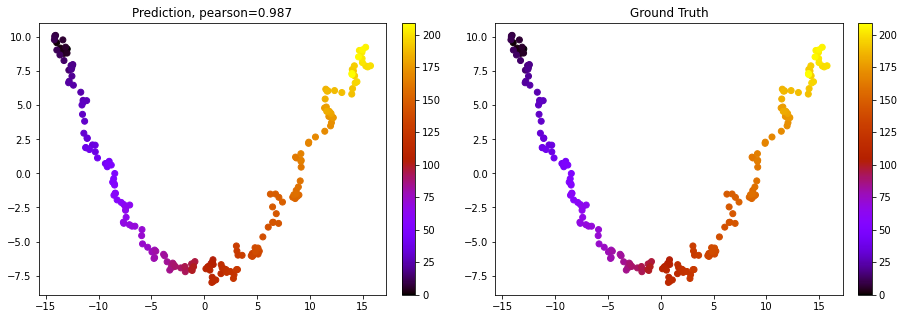

<Figure size 1080x360 with 0 Axes>

0.99451256


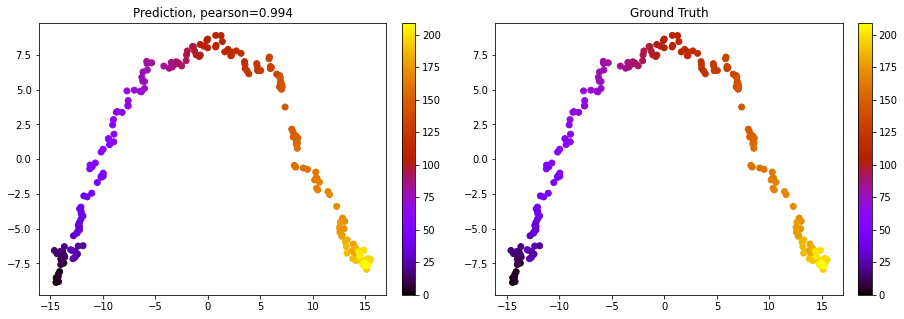

<Figure size 1080x360 with 0 Axes>

0.98976475


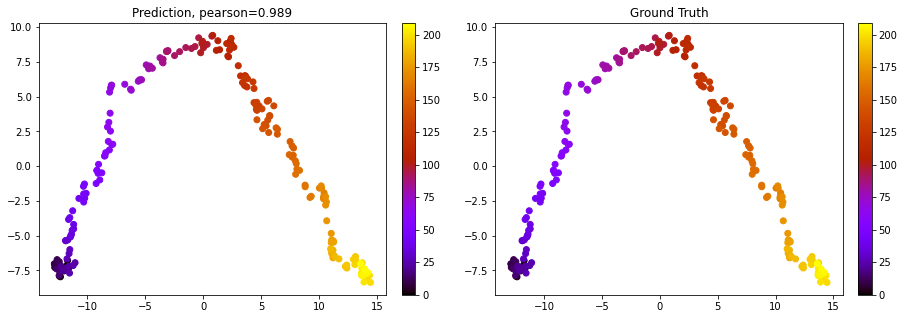

<Figure size 1080x360 with 0 Axes>

0.98190427


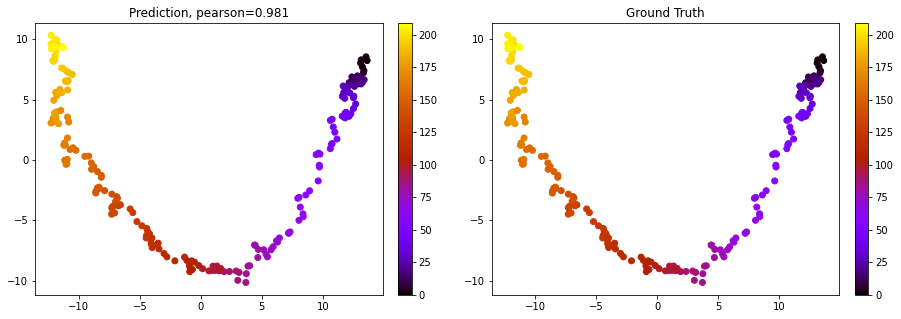

<Figure size 1080x360 with 0 Axes>

0.9857804


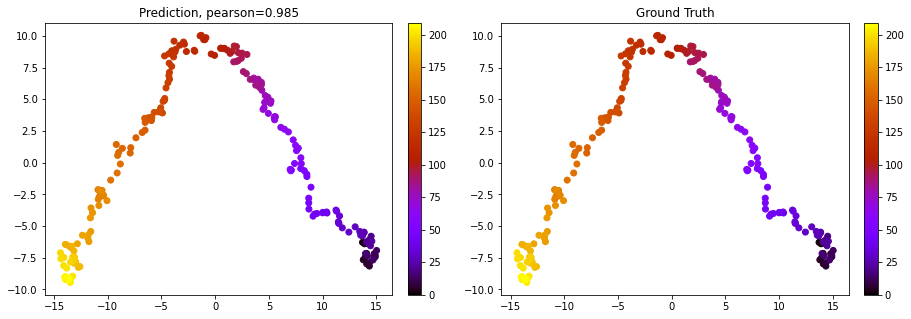

<Figure size 1080x360 with 0 Axes>

0.989281


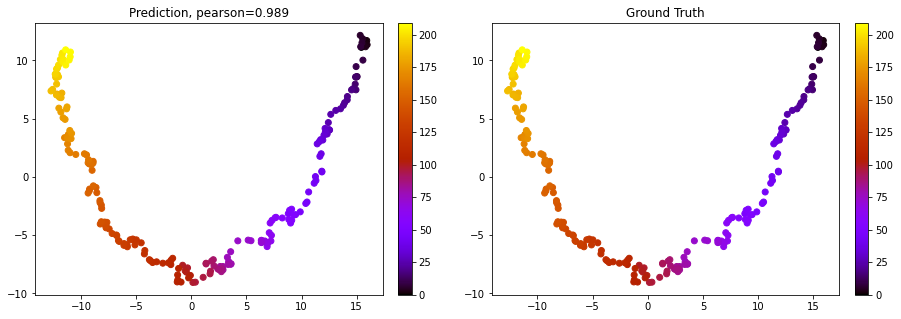

<Figure size 1080x360 with 0 Axes>

0.9847923


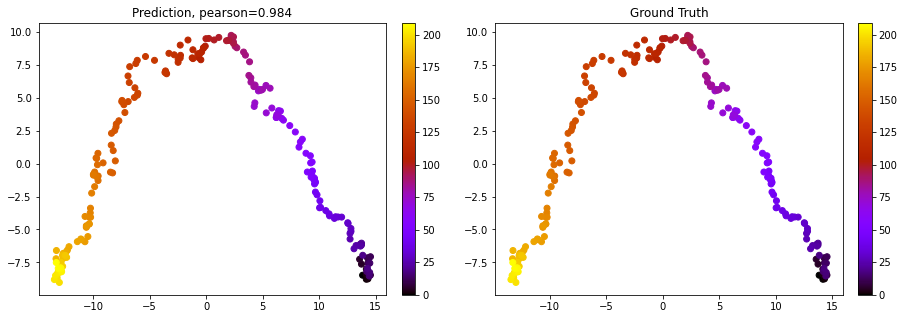

<Figure size 1080x360 with 0 Axes>

0.98372823


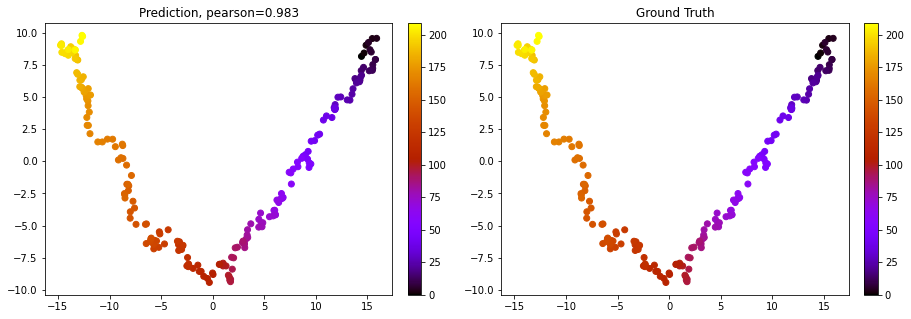

<Figure size 1080x360 with 0 Axes>

0.9815275


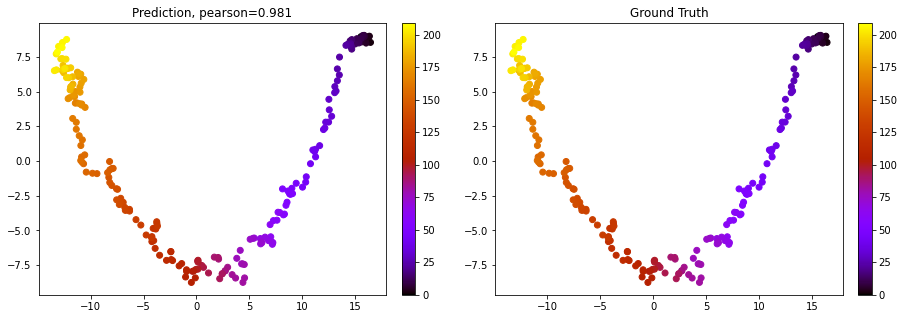

<Figure size 1080x360 with 0 Axes>

0.99149203


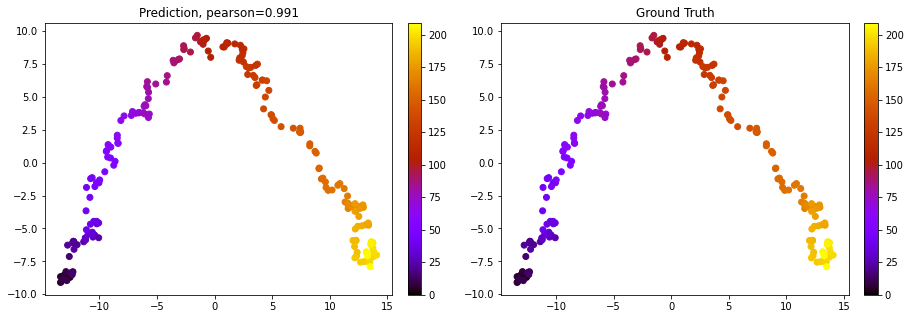

<Figure size 1080x360 with 0 Axes>

0.98844665


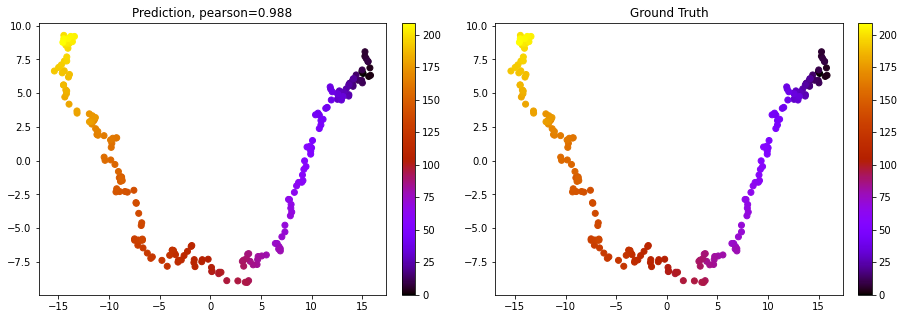

<Figure size 1080x360 with 0 Axes>

0.97647905


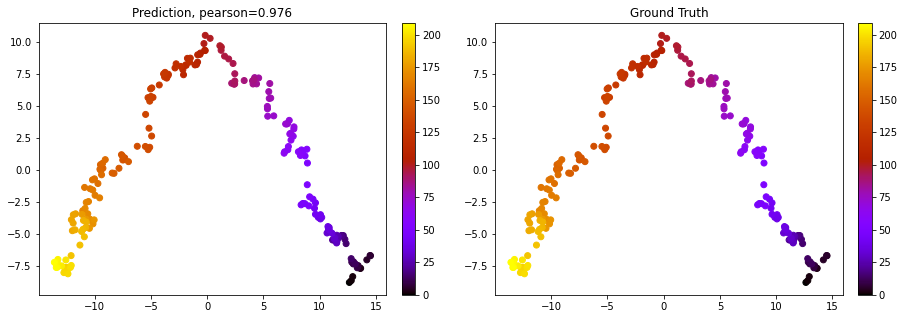

<Figure size 1080x360 with 0 Axes>

0.98681784


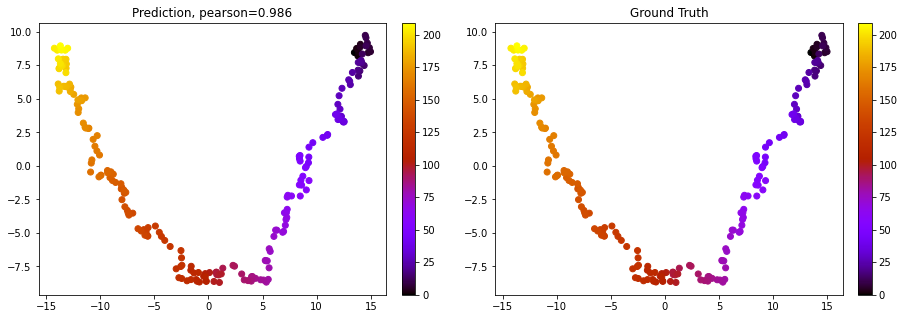

<Figure size 1080x360 with 0 Axes>

0.98630416


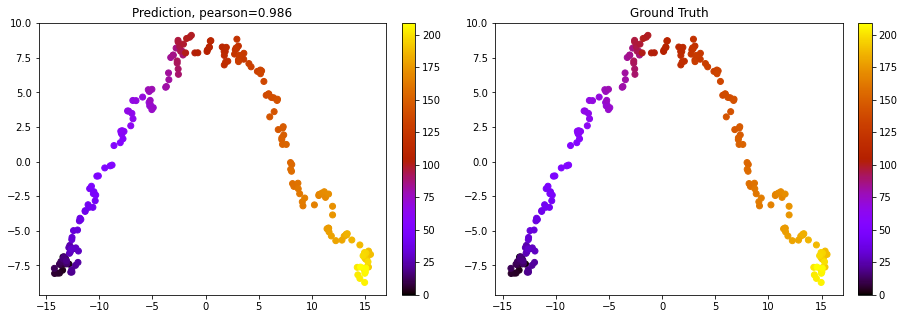

<Figure size 1080x360 with 0 Axes>

0.98111326


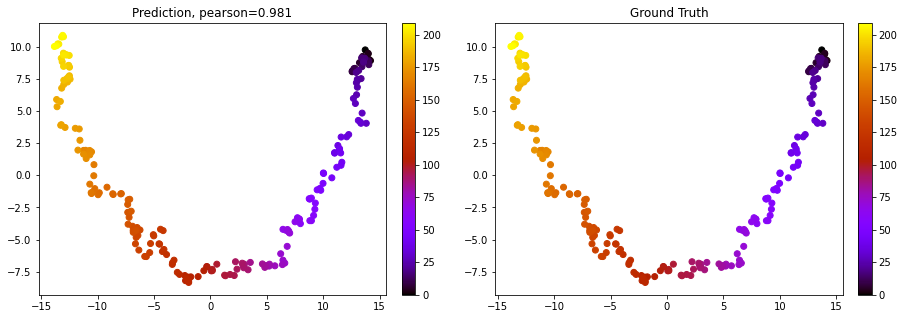

<Figure size 1080x360 with 0 Axes>

In [9]:
linear_loader = DataLoader(datatest[val_mask], batch_size=1, shuffle=True)

for data in linear_loader:
    utils.scatter(model, data, method='pca', metric='pearson', coloring="order")